<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Authors:_ Joseph Nelson (DC), Boom Devahastin Na Ayudhya (NYC), Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [66]:
#the dates are all fridays, format is YYYY-MM-DD
data.index

Index(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05',
       '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09',
       ...
       '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14', '2012-09-21',
       '2012-09-28', '2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'],
      dtype='object', name='Date', length=421570)

In [67]:
data.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [68]:
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [69]:
data['Date'] = data.index
temp1 = data.loc[data.Store == 1]
temp1

,Store,Dept,Weekly_Sales,IsHoliday,Date
Date,,,,,
2010-02-05,1,1,24924.50,False,2010-02-05
2010-02-12,1,1,46039.49,True,2010-02-12
2010-02-19,1,1,41595.55,False,2010-02-19
2010-02-26,1,1,19403.54,False,2010-02-26
2010-03-05,1,1,21827.90,False,2010-03-05
...,...,...,...,...,...
2012-08-31,1,99,20.06,False,2012-08-31
2012-09-07,1,99,0.05,True,2012-09-07
2012-09-14,1,99,0.03,False,2012-09-14


In [70]:
output_list = list(temp1.Date.values.tolist())

output = []
for x in output_list:
    if x not in output:
        output.append(x)

date_list = output
total_sales = []

In [71]:
for i in date_list:
    temp2 = temp1.loc[temp1.Date == str(i)]
    total_sales.append(temp2.Weekly_Sales.sum())

In [72]:
zipped = list(zip(date_list, total_sales))
Weekly_Sales = pd.DataFrame(zipped, columns=['Date', 'Total Sales'])

In [73]:
Weekly_Sales

,Date,Total Sales
0,2010-02-05,1643690.90
1,2010-02-12,1641957.44
2,2010-02-19,1611968.17
3,2010-02-26,1409727.59
4,2010-03-05,1554806.68
...,...,...
138,2012-09-28,1437059.26
139,2012-10-05,1670785.97
140,2012-10-12,1573072.81
141,2012-10-19,1508068.77


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

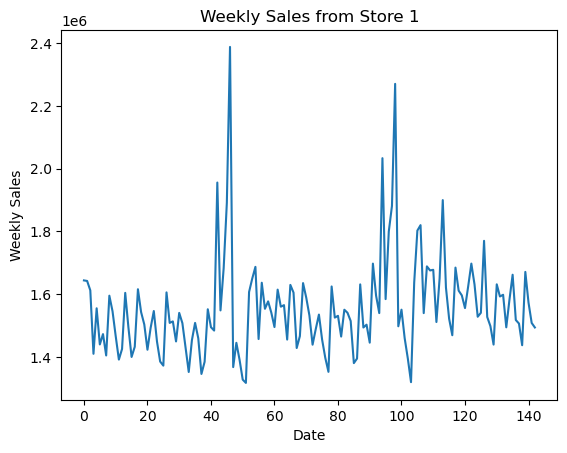

In [74]:
x = Weekly_Sales.index
y = Weekly_Sales['Total Sales']
  
plt.plot(x, y)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales from Store 1')
plt.show()

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

In [75]:
Weekly_Sales['Rolling 4'] = Weekly_Sales['Total Sales'].rolling(4).mean()

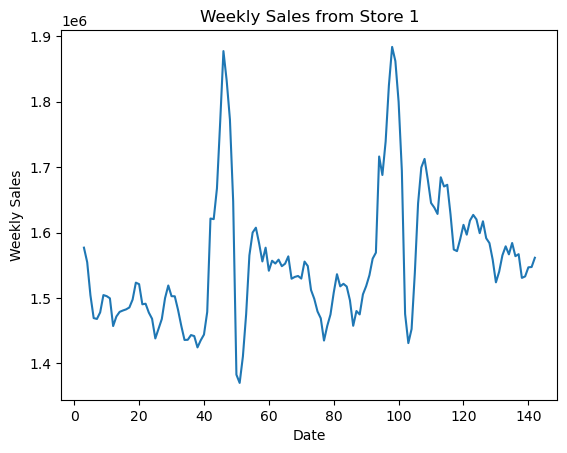

In [76]:
x = Weekly_Sales.index
y = Weekly_Sales['Rolling 4']
  
plt.plot(x, y)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales from Store 1')
plt.show()

**2c. What can you say about trends in the data based on the rolling mean plot above?**

There seems to be some cyclical trend after the smoothing.

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

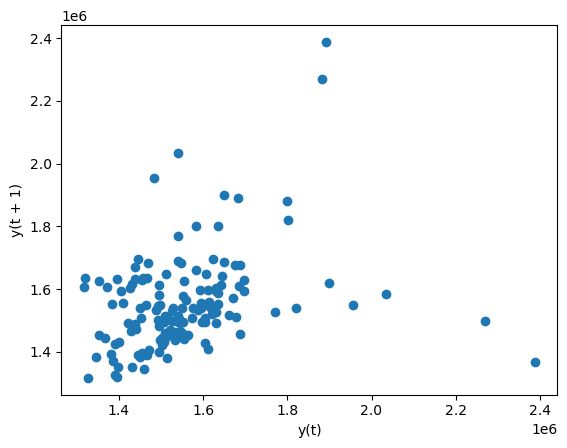

In [77]:
pd.plotting.lag_plot(Weekly_Sales['Total Sales'], lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 2)'>

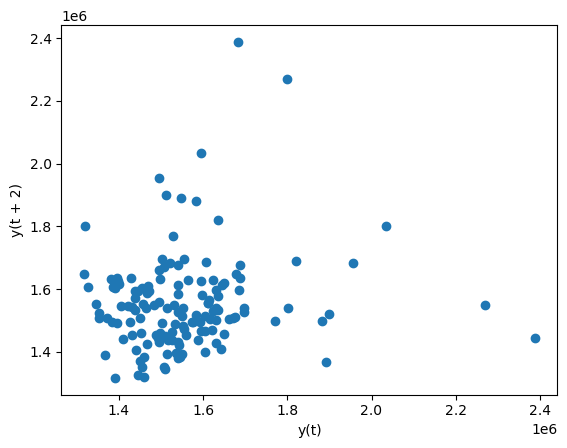

In [78]:
pd.plotting.lag_plot(Weekly_Sales['Total Sales'], lag=2)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 52)'>

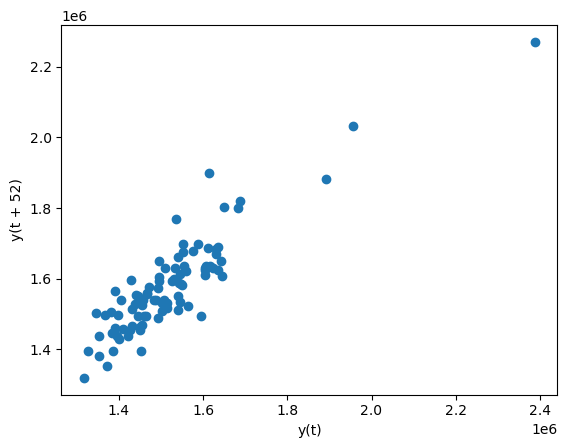

In [79]:
pd.plotting.lag_plot(Weekly_Sales['Total Sales'], lag=52)

**3b. What can you say about the series based on these autocorrelations?**

Answer:

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

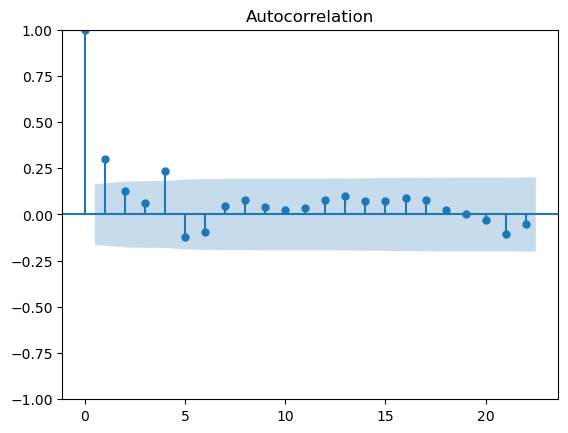

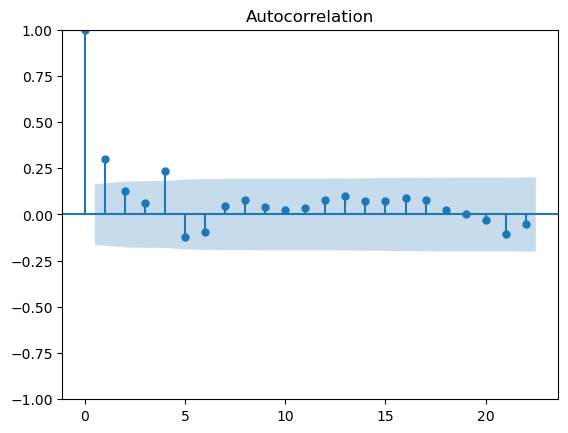

In [80]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Weekly_Sales['Total Sales'])

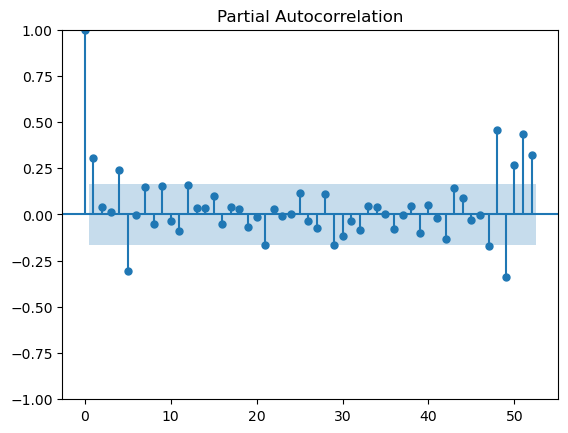

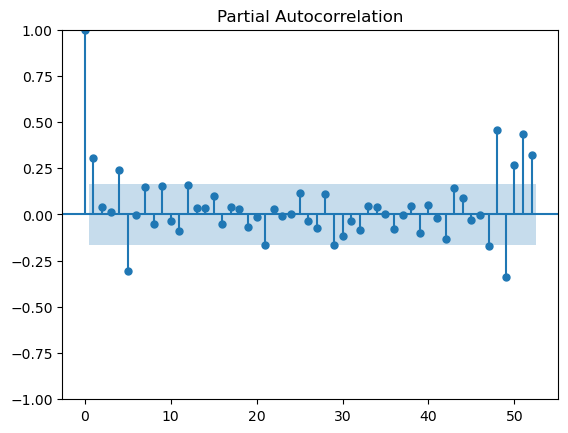

In [81]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(Weekly_Sales['Total Sales'], lags=52)

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

There is strong autocorrelation with first order difference and after one year.

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Help us to decide how we want to remove the cyclical effect as seen in the autocorrelation.

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [82]:
print(0.75 * len(Weekly_Sales))
train = Weekly_Sales.iloc[0:107]
test = Weekly_Sales.iloc[108:]

107.25


#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. In each section, we will add additional ARIMA parameters in an effort to improve our modeling. Note that sometimes the model you attempt is not effective or the best -- try the BONUS sections below to see other approaches to modeling this dataset!

- Note that this is the same thing as an `ARIMA(1,0,0)` model.
- Pass in the Weekly Sales as an `ndarray`, not a `Series`.
- Pass in the training index using the ARIMA `dates` parameter.

**6a. Instantiate and fit an `AR(1)` model.**

In [83]:
import statsmodels.api as sm
arima_100 = sm.tsa.arima.ARIMA(train['Total Sales'], order=(1, 0, 0)).fit()
print(arima_100.summary())

                               SARIMAX Results                                
Dep. Variable:            Total Sales   No. Observations:                  107
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1434.664
Date:                Fri, 09 Dec 2022   AIC                           2875.329
Time:                        22:34:20   BIC                           2883.347
Sample:                             0   HQIC                          2878.579
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   2.74e+04     56.276      0.000    1.49e+06     1.6e+06
ar.L1          0.3147      0.056      5.638      0.000       0.205       0.424
sigma2      2.605e+10      0.216    1.2e+11      0.0

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [84]:
from sklearn.metrics import mean_squared_error
Y_true = train['Total Sales']
Y_pred_100 = arima_100.predict()
mean_squared_error(Y_true,Y_pred_100)

25903503058.353

**6c. How effective do you think this `AR(1)` model is?**

The error seems to be quite big.

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

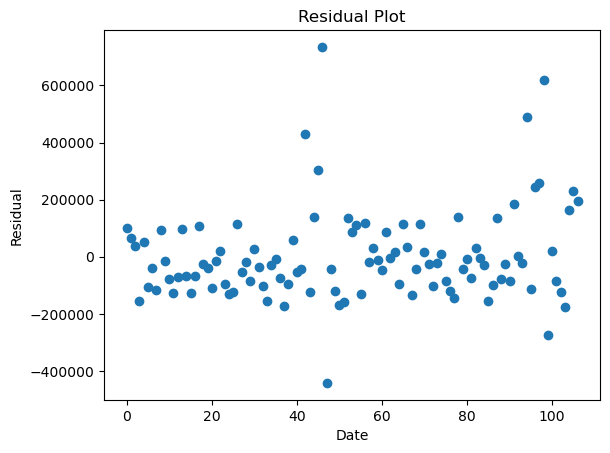

In [85]:
residual_100 = Y_true - Y_pred_100

x = train.index
y = residual_100
  
plt.scatter(x, y)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

To see after removing the cyclical effect, whether the residual is random (stationary points).

#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [86]:
arima_200 = sm.tsa.arima.ARIMA(train['Total Sales'], order=(2, 0, 0)).fit()
print(arima_200.summary())

                               SARIMAX Results                                
Dep. Variable:            Total Sales   No. Observations:                  107
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1434.487
Date:                Fri, 09 Dec 2022   AIC                           2876.974
Time:                        22:34:20   BIC                           2887.665
Sample:                             0   HQIC                          2881.308
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   2.94e+04     52.559      0.000    1.49e+06     1.6e+06
ar.L1          0.2973      0.082      3.647      0.000       0.138       0.457
ar.L2          0.0589      0.138      0.426      0.6

In [87]:
Y_true = train['Total Sales']
Y_pred_200 = arima_200.predict()
mean_squared_error(Y_true,Y_pred_200)

25814337771.780777

**8b. How did your results change?**

It is slightly better.

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [88]:
arima_202 = sm.tsa.arima.ARIMA(train['Total Sales'], order=(2, 0, 2)).fit()
print(arima_202.summary())

                               SARIMAX Results                                
Dep. Variable:            Total Sales   No. Observations:                  107
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1426.207
Date:                Fri, 09 Dec 2022   AIC                           2864.414
Time:                        22:34:21   BIC                           2880.451
Sample:                             0   HQIC                          2870.915
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.544e+06   2.57e+04     60.151      0.000    1.49e+06    1.59e+06
ar.L1         -1.0337      0.081    -12.737      0.000      -1.193      -0.875
ar.L2         -0.4670      0.077     -6.039      0.0

In [89]:
Y_true = train['Total Sales']
Y_pred_202 = arima_202.predict()
mean_squared_error(Y_true,Y_pred_202)

21601543613.032906

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



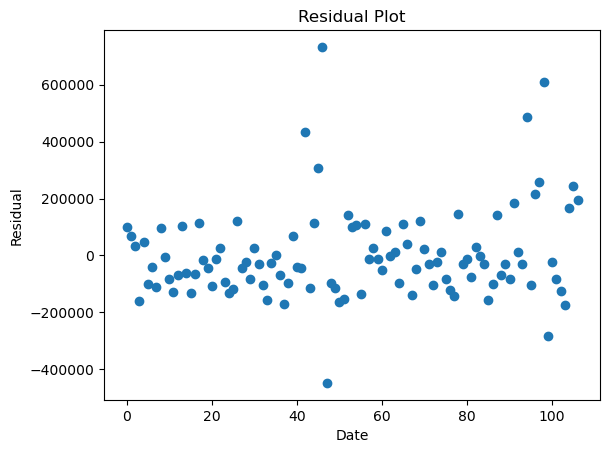

In [90]:
residual_200 = Y_true - Y_pred_200

x = train.index
y = residual_200
  
plt.scatter(x, y)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

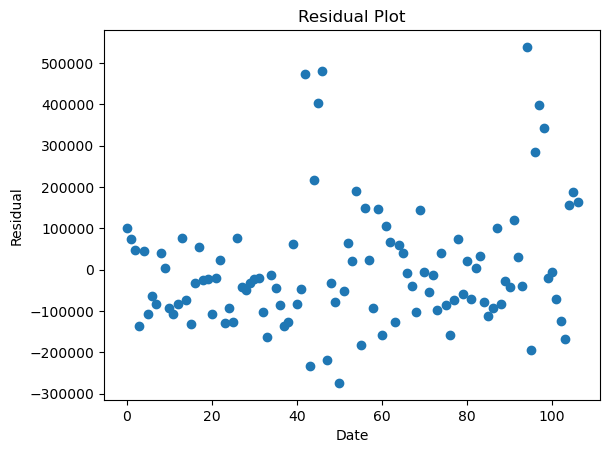

In [91]:
residual_202 = Y_true - Y_pred_202

x = train.index
y = residual_202
  
plt.scatter(x, y)
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

Answer:

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [92]:
result = adfuller(train['Total Sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.688682
p-value: 0.000088
Critical Values:
	1%: -3.496
	5%: -2.890
	10%: -2.582


**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer:

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
 Another column should be `Weekly_Sales` differenced by 4 time periods.

In [93]:
train['Period1'] = (train['Total Sales'].diff())
train['Period2'] = (train['Total Sales'].diff(2))
train['Period3'] = (train['Total Sales'].diff(3))
train['Period4'] = (train['Total Sales'].diff(4))

**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [94]:
result = adfuller(train['Period1'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.179642
p-value: 0.000000
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


In [95]:
result = adfuller(train['Period2'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.368909
p-value: 0.000004
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583


In [96]:
result = adfuller(train['Period3'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.772342
p-value: 0.000061
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


In [97]:
result = adfuller(train['Period4'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.059868
p-value: 0.000000
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583


**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer:

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer:

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [98]:
arima_272 = sm.tsa.arima.ARIMA(train['Total Sales'], order=(2, 7, 2)).fit()
print(arima_272.summary())

                               SARIMAX Results                                
Dep. Variable:            Total Sales   No. Observations:                  107
Model:                 ARIMA(2, 7, 2)   Log Likelihood               -1548.237
Date:                Fri, 09 Dec 2022   AIC                           3106.473
Time:                        22:34:21   BIC                           3119.499
Sample:                             0   HQIC                          3111.745
                                - 107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3016      0.246     -5.290      0.000      -1.784      -0.819
ar.L2         -0.5070      0.244     -2.078      0.038      -0.985      -0.029
ma.L1         -1.9111      0.260     -7.349      0.0

**11b. Interpret the results from the last answer.**


Answer:

#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [99]:
model =sm.tsa.statespace.SARIMAX(train['Total Sales'],order=(2, 0, 2),seasonal_order=(1,0,0,4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Total Sales   No. Observations:                  107
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 4)   Log Likelihood               -1450.663
Date:                            Fri, 09 Dec 2022   AIC                           2913.327
Time:                                    22:34:21   BIC                           2929.364
Sample:                                         0   HQIC                          2919.828
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3421      0.072      4.725      0.000       0.200       0.484
ar.L2         -0.4999      0.055     -9.144      0.000      -0.607      -0.393
ma.L1         -0.0508      0.026     -1.962      0.050      -0.102   -4.23e-05
ma.L2          0.9996      0.115      8.666      0.000       0.774       1.226
ar.S.L4        0.9882      0.013     78.932      0.000       0.964       1.013
sigma2      2.965e+10   3.91e-12   7.59e+21      0.000    2.97e+10    2.97e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):                28.56
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               4.14   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.43e+37. Standard errors may be unstable.
"""

In [100]:
Y_true = train['Total Sales']
Y_pred_sarimax = results.predict()
mean_squared_error(Y_true,Y_pred_sarimax)

65867708982.88912

**12b. How did your best SARIMAX model perform?**

Answer:

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: 

**13c. How might you improve it?**

Answer:

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: